# Fitting a straight line to data

AST 3414 - Spring 2026

## Introduction

In this lab, you'll use **Bayesian inference** and **Markov Chain Monte Carlo (MCMC)** to fit a straight line to data. We are following the procedure laid out in [Hogg et al. (2010)](https://arxiv.org/abs/1008.4686).

### What You'll Learn

1. **Bayesian inference** - Sample the full posterior distributions, and allows for flexibility in constructing a generative model for your data
2. **Prior selection** - Choose and justify reasonable priors
3. **Posterior analysis** - Interpret MCMC chains and corner plots
4. **emcee** - Use the affine-invariant ensemble sampler

### Key Differences from χ² Fitting

**Traditional χ² minimization**:
- Finds single "best-fit" parameters
- Assumes errors only in y-axis (distance)
- Uncertainties from curvature at minimum
- Fast but limited

**Bayesian MCMC**:
- Samples full posterior probability distribution P(θ|data)
- Handles errors in both x and y; can model bad data points
- Incorporates prior knowledge
- Provides complete uncertainty quantification
- More computation but more rigorous

---

## Bayes' Theorem

$$P(\theta | D) = \frac{P(D | \theta) \cdot P(\theta)}{P(D)}$$

**Translation**:
$$\text{Posterior} = \frac{\text{Likelihood} \times \text{Prior}}{\text{Evidence}}$$

For parameter estimation, we can ignore the evidence (normalization):

$$P(\theta | D) \propto P(D | \theta) \cdot P(\theta)$$

**What we need to define**:
1. **Likelihood** $P(D | \theta)$: How probable is our data given parameters?
2. **Prior** $P(\theta)$: What do we know about parameters before seeing data?

MCMC then samples from the posterior using multiple "walkers" that explore the parameter space in parallel to give us the full probability distribution! This is efficient for multi-dimensional problems (~10-20 parameters) and is widely used in astrophysics.

---
**This is a Pair Programming Lab** - Please work together with all members looking at the same copy of the code on one computer. One member will be the **Driver** who controls the keyboard. The others will be the **Navigator(s)** who reviews code and think strategically, giving instructions to the Drive.

Every 20-30 minutes an announcement will be made to switch roles.

## Requirements

For this activity we are using the following packages, along with their dependencies, all of which are included by default for Colab.

- [NumPy](http://numpy.org) (Numerical Python) for efficient manipulation of array-based data
- [SciPy](http://scipy.org) (Scientific Python) for optimization and other routines
- [Pandas](http://pandas.pydata.org) for reading data files into arrays
- [Matplotlib](http://matplotlib.org) for scientific visualization


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize

#from scipy.optimize import curve_fit
#from matplotlib.ticker import MaxNLocator

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10, 6)
print("Ready!")

Ready!


There are also a few packages we will use that are not part of the default Colab.

- [emceee](https://emcee.readthedocs.io/en/stable/) for Markov Chain Monte Carlo sampling of Bayesian posteriors.
- [corner.py](https://corner.readthedocs.io/en/latest/) for visualization of multidimensional posteriors using "corner plots".

These are installed by running the following line of code, using the ``pip`` command

In [ ]:
!pip install -q emcee
!pip install -q corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.7 MB/s eta 0:00:00


We also need to define our model, a straight line with a slope and intercept,
$$
y_M(x) = mx + b,
$$

and define variables $x$, $y$, $\sigma_x$, $\sigma_y$, and $\rho_{xy}$ for the dataset from [Hogg et al. (2010)](https://arxiv.org/abs/1008.4686)

In [ ]:
def line(x, m, b):
    return m * x + b

# Data form Table 1 of Hogg, et al. (2010) as numpy arrays
x = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146], dtype = float)
y = np.array([592, 401, 583, 402, 495, 173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344], dtype = float)

sigma_y = np.array([61, 25, 38, 15, 21, 15, 27, 14, 30, 16, 14, 25, 52, 16, 34, 31, 42, 26, 16, 22], dtype = float)
sigma_x = np.array([9, 4, 11, 7, 5, 9, 4, 4, 11, 7, 5, 5, 5, 6, 6, 5, 9, 8, 6, 5], dtype = float)

rho_xy = np.array([-0.84, 0.31, 0.64, -0.27, -0.33, 0.67, -0.02, -0.05, -0.84, -0.69, 0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 0.90, 0.40, -0.78, -0.56], dtype = float)
# rhoxy is used to determine the full covariance matrix for each data point.


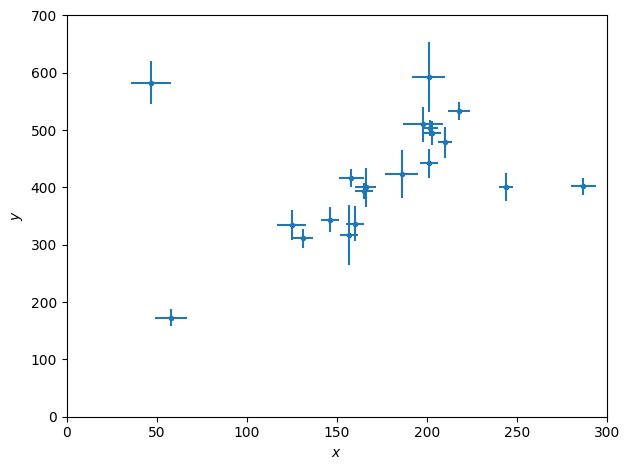

In [ ]:
# Take a quick look at our data
plt.errorbar(x, y, xerr = sigma_x, yerr = sigma_y, marker = ".", linestyle = "")
plt.xlim(0, 300)
plt.ylim(0, 700)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()

---
## Part 1. Least-squares fit

The "standard practice" as described in Hogg, et al. (2010), uses matrix multiplication. We use numpy to construct the matrices ${\bf A}$ and ${\bf C}$ such that:
$\theta = {\bf X} = [{\bf A}^T {\bf C}^{-1} {\bf A}]^{-1}[{\bf A}^T{\bf C}^{-1} {\bf Y}]$, where $\theta = [\substack{b\\m}]$ is the parameter vector containing the intercept and slope, ${\bf C}$ is the covariance matrix, and ${\bf A} = \big[\substack{1 \ x_1\\...\\1 \ x_N}\big]$.

See the paper for details about why this works, but it is essentially minimizing the $\chi^2$ objective function:
$
\chi^2 = \sum^N_{i=1}\frac{[y_i-f(x_i)]^2}{\sigma_{yi}^2} = [{\bf Y-AX}]^T {\bf C}^{-1} [{\bf Y-AX}].
$

The fit to the **entire** dataset is shown below.

Least-squares results (all data):
    m = 1.076747524168327 ± 0.0774067831657561
    b = 213.27349197596124 ± 14.39403310716221



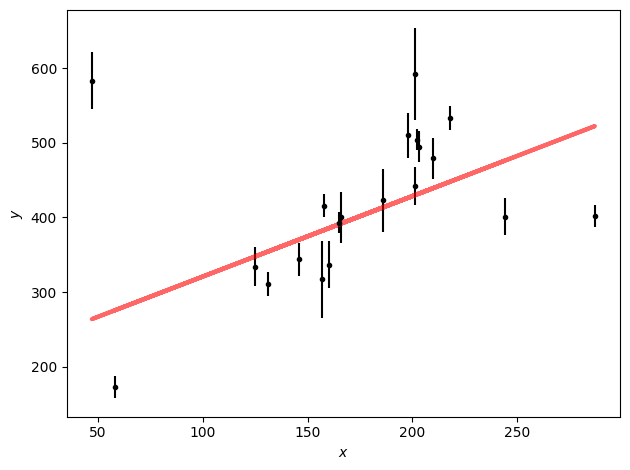

In [ ]:
# fitting all the data
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(sigma_y * sigma_y)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

print("""Least-squares results (all data):
    m = {0} ± {1}
    b = {2} ± {3}
""".format(m_ls, np.sqrt(cov[1, 1]), b_ls, np.sqrt(cov[0, 0])))

plt.errorbar(x, y, yerr=sigma_y, fmt=".k")
plt.plot(x, line(x, m_ls, b_ls), "r", lw=3, alpha=0.6)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()

### Question 1

There are some pretty egregious outlier points in the dataset. Hogg suggests excluding the first four data points. Repeat the linear least squares fit using only data points 5 through 20. Remember that python starts index arrays at 0, not 1. Make a plot of the two models. How do the differences between the two fitted slopes compare to the estimated errors from each fit. How sensitive is a least-squares fit to outliers?

In [ ]:
# YOUR CODE HERE

## Part 2. Simple Bayesian Modeling

For a Bayesian, models are a **probability distribution** for our data. We need an expression to compute the likelihood $P(D\mid\theta)$ for our data as a function of the parameters $\theta$.

To start we will continue to ignore the errors for the x data and only include y errors, and include all data points without accounting for the possibility that some are outliers ("bad data"). We do this to get familiar with the basics of Bayesian inference.

Assuming all the points are independent, we can find the full likelihood by multiplying the individual likelihoods together:

$$
P(D\mid\theta) = \prod_{i=1}^N P(x_i,y_i\mid\theta)
$$

For convenience (and also for numerical accuracy) this is often expressed in terms of the log-likelihood:

$$
\log P(D\mid\theta) = -\frac{1}{2}\sum_{i=1}^N\left(\log(2\pi\sigma_{yi}^2) + \frac{\left[y_i - y_M(x_i;\theta)\right]^2}{\sigma_{yi}^2}\right)
$$

The python code below computers the log-likelihood given a parameter vector $\theta$, an array of of $x$ and $y$ values, and an array of errors $\sigma_{y}$. Then we use tools in [``scipy.optimize``](http://docs.scipy.org/doc/scipy/reference/optimize.html) to maximize this likelihood (i.e. minimize the negative log-likelihood).

In [ ]:
m_guess = 0 # our guess for the slope
b_guess = 0 # our guess for the intercept

def log_likelihood(theta, x, y, dy):
    y_model = theta[0] + theta[1] * x
    return -0.5 * np.sum(np.log(2 * np.pi * dy ** 2) +
                         (y - y_model) ** 2 / dy ** 2)

def minfunc(theta, x, y, dy):
    return -log_likelihood(theta, x, y, dy)

result = optimize.minimize(minfunc, x0=[b_guess, m_guess], args=(x, y, sigma_y))

print("""Simple log likelihood maximization results (all data):
    m = {0} ± {1}
    b = {2} ± {3}
""".format(result.x[1], np.sqrt(0.5*result.hess_inv[1, 1]), result.x[0], np.sqrt(0.5*result.hess_inv[0, 0])))

if result.success == True: print ("Your fit suceeded!")
else: print("WARNING: Fit failed! Adjust the initial guess and try again.")

Simple log likelihood maximization results (all data):
    m = 1.076747421200126 ± 0.014445561515859948
    b = 213.273537391257 ± 0.2651961176463616



### Question 2

Try changing the initial guess for the slope and intercept to something other than zero. Verify whether your changes affect the best-fit parameters. For what ranges is our fit robust (successful fit) and for what range does the fit fail?

### Priors

We have computed the likelihood, now we need to think about the prior $P(\theta\mid I)$. This is where Bayesianism gets a bit controversial... what can we actually say about the slope and intercept before we fit our data?

There are a couple approaches to choosing priors that you'll come across in practice:

### 1. Empirical Priors

Empirical Priors are priors which are actually posteriors from previous studies of the same phenomenon. For example, it's common in Supernova cosmology studies to use the WMAP results as a prior: that is, we actually plug-in a *real result* and use our new data to improve on that. This situation is where Bayesian approaches really shine.

For our linear fit, you might imagine that our $x, y$ data is a more accurate version of a previous $\chi^2$ fit. In that case, we'd encode this prior knowledge in the prior distribution itself.

### 2. Flat Priors

If you don't have a physical reason to establish a prior, you might be tempted to simply use a *flat prior* – i.e. a prior that is constant between two reasonable limits (i.e. equal probability slopes from -20 to +20).

The problem is that flat priors are not always non-informative! For example, a flat prior on the slope will effectively give a higher weight to larger slopes.
We can see this straightforwardly by plotting regularly-spaced slopes between 0 and 20:

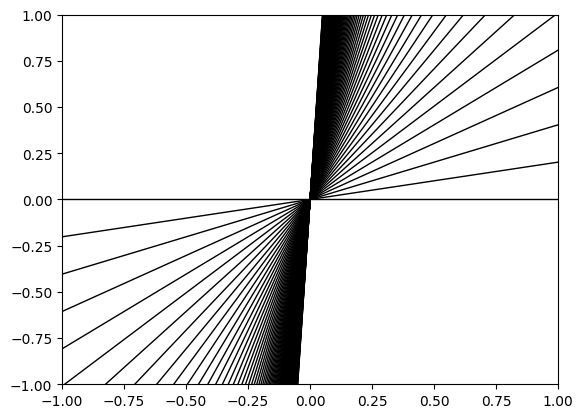

In [ ]:
xx = np.linspace(-1, 1)
for slope in np.linspace(0, 20, 100):
    plt.plot(xx, slope * xx, '-k', linewidth=1)
plt.axis([-1, 1, -1, 1]);

The density of the lines is a proxy for the probability of those slopes with a flat prior.
This is an important point to realize: **flat priors are not necessarily minimally informative**.

### 3. Non-informative Priors

What we *really* want in cases where no empirical prior is available is a **non-informative prior**. Among other things, such a prior should not depend on the units of the data.

In the case of the linear slope, we often want a prior which does not artificially over-weight large slopes: there are a couple possible approaches to this (see http://arxiv.org/abs/1411.5018 for some discussion). For our situation, we might use a flat prior on the angle the line makes with the x-axis, which gives

$$
P(m) \propto (1 + m^2)^{-3/2}
$$

For lack of a better term, I like to call this a "symmetric prior" on the slope (because it's the same whether we're fitting $y = mx + b$ or $x = m^\prime y + b^\prime$).

Let's define two python functions to compute the options for our prior: we'll use both a (log) flat prior and a (log) symmetric prior.
In general, we need not worry about the normalization of the prior or the likelihood, which makes our lives easier:


In [ ]:
def log_flat_prior(theta, bounds=None):
    if bounds is None:
        # Default bounds (adjust these based on your data)
        bounds = [
            (-500, 500),      # b: intercept
            (-5, 5),      # m: slope
        ]

    # Check if all parameters are within bounds
    for param, (lower, upper) in zip(theta, bounds):
        if not (lower < param < upper):
            return  -np.inf

    # Uniform prior: all values within bounds are equally likely
    return  0  # log(1)


def log_symmetric_prior(theta):
    if np.abs(theta[0]) < 1000:
        return -1.5 * np.log(1 + theta[1] ** 2)
    else:
        return -np.inf  # log(0)

But does all this hand wringing about priors actually make a difference for our fit? It depends on how informative is your data.

With each prior defined, we can compute the log posterior probability as a function of the model parameters, and then plot 1, 2, and 3-sigma contours for the best-fit parameters on a two-dimensional grid (i.e. a contour plot).

***Look throught the code below, confirm that it works, and that you understand each line. How different are the posteriors found using our two different priors?***

[0.00572893 0.09712339 0.52781448]


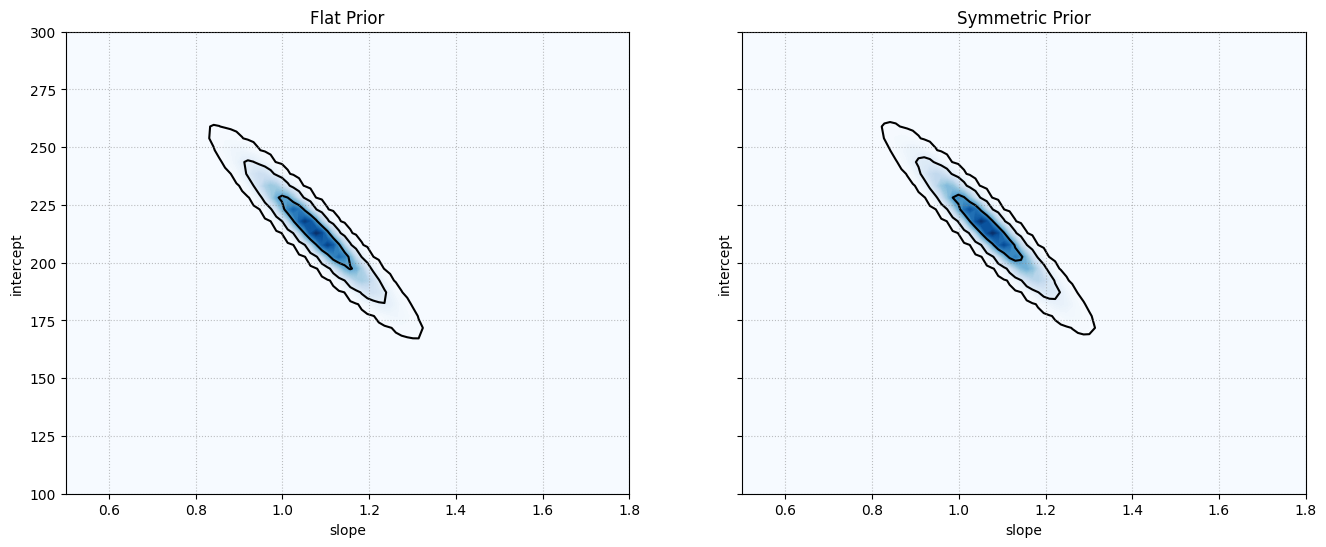

In [ ]:
def contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior"""
    sorted_ = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(sorted_) / np.sum(sorted_)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997]) ** 2)
    return sorted_[cutoffs]

#set reasonable bounds for parameters
slope_range = np.linspace(0.5, 1.8, 100)
intercept_range = np.linspace(100., 300., 40)

# Computing the posterior probability for the data
log_P1 = [[log_likelihood([b, m], x, y, sigma_y) + log_flat_prior([b, m])
           for m in slope_range] for b in intercept_range]
log_P2 = [[log_likelihood([b, m], x, y, sigma_y) + log_symmetric_prior([b, m])
           for m in slope_range] for b in intercept_range]

# For convenience, we normalize the probability density such that the maximum is 1
P1 = np.exp(log_P1 - np.max(log_P1))
P2 = np.exp(log_P2 - np.max(log_P2))

# 2. Create two subplots and plot contours showing the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       sharex=True, sharey=True)

ax[0].contourf(slope_range, intercept_range, P1, 100, cmap='Blues')
# Sort contour levels in ascending order
sorted_P1_levels = np.sort(contour_levels(P1))
print(sorted_P1_levels)
ax[0].contour(slope_range, intercept_range, P1, sorted_P1_levels, colors='black')
ax[0].set_title('Flat Prior')

ax[1].contourf(slope_range, intercept_range, P2, 100, cmap='Blues')
# Sort contour levels in ascending order
sorted_P2_levels = np.sort(contour_levels(P2))
ax[1].contour(slope_range, intercept_range, P2, sorted_P2_levels, colors='black')
ax[1].set_title('Symmetric Prior')

# 3. Add grids and set axis labels
for axi in ax:
    axi.grid('on', linestyle=':', color='gray', alpha=0.5)
    axi.set_axisbelow(False)
    axi.set_xlabel('slope')
    axi.set_ylabel('intercept')


Here, the bias of the flat prior does not seem to matter, because the strength of our data is still able to provide a robust fit.

# Part 3. Mixture Model to account for outliers

Using a Bayesian formulation hasn't really improved our staright line fit at all so far because our objective function hasn't accounted for the outlier data points. Remember, the strength of the Baysian approach is that we can add nusiance parameters to our model that provie a better description. We then marginalize out these nuisance parameters, and are left with more accurate estimates on those model parameters we do care about.

[Hogg et al. (2010)](https://arxiv.org/abs/1008.4686) proposes a mixture model in which we have two sources of points that explain those in the table, both a "foreground" and a "background" model. The foreground model is just our straight line with Gaussian errors. The background model is that outlier points are drawn from some Gaussian distribution with mean $M$ and variance $V$. We also need to include a probablity (or fraction) that a data point comes from our straight line. This adds *three* new parameters to the existing slope and intercept, so our parameters are, in order:
 - `m`: slope of the linear model
 - `b`: y-intercept of the linear model
 - `Q`: fraction of foreground points (0 < Q < 1)
 - `Mb`: mean of the background distribution
 - `lnVb`: log of the intrinsic scatter in the background (we use log to ensure positivity)
  
### Define the likelihood, prior and posterior

The foreground likelihood for this model looks very similar to what we used above,

$$
P_{fg} (x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi\sigma_{yi}^2}} \exp\left(\frac{-\left[y_i - m x_i - b\right]^2}{2\sigma_{yi}^2}\right),
$$

and the background likelihood looks very similar except that it's x and y values are offset by a Gaussian with mean $M$ and variance $V$,
$$
P_{bg} (x_i,y_i\mid\theta) = \frac{1}{\sqrt{2\pi(V_b+\sigma_{yi}^2)}} \exp\left(\frac{-\left[y_i - M_b\right]^2}{2(V_b+\sigma_{yi}^2)}\right).
$$

The total likleihood for our generative model is the product of the foreground and background likelihoods weighted by the appropriate fraction of total points:

$$
\mathcal{L} = \prod^N_{i=1} Q P_{fg} + (1-Q) P_{bg}
$$

For our priors, we will assume values are uniform within some bounds. You should set bounds based on the data range and any physical constraints. In particular, $Q$ should be between 0 and 1 since it is a probability, and $M$ should cover at least the range of our y-values since it is the background mean.

Finally, the posterior can be defined in the usual way by multiplying the likelihood and prior probability distributions. However, we want to use the log of the prior, likelihood, and posterior functions for better numerical accuracy. In this case the log of the prior is just the log of the likelihood plus the log of the prior.

In [157]:
import emcee

def lnflatprior(theta, bounds=None):
    if bounds is None:
        # Default bounds (adjust these based on your data)
        bounds = [
            (-100, 500),      # b: intercept
            (0, 5),      # m: slope
            (0.0, 1.0),   # Q: foreground fraction
            (0, 1000),    # M: background mean
            (-1, 20)     # lnV: log background variance
        ]
    # Check if all parameters are within bounds
    for param, (lower, upper) in zip(theta, bounds):
        if not (lower < param < upper):
            return -np.inf
    # Uniform prior: all values within bounds are equally likely
    return 0.0

def lnlike_fg(theta):
    b, m, _, Mm, lnV = theta
    model = m * x + b
    return -0.5 * (((model - y) / sigma_y) ** 2 + 2 * np.log(sigma_y))
    # We drop the constant -0.5*ln(2*pi) term

def lnlike_bg(theta):
    _, _, _, Mm, lnV = theta
    # Total variance = intrinsic scatter + measurement error
    var = np.exp(lnV) + sigma_y**2
    # We drop the constant -0.5*ln(2*pi) term
    return -0.5 * (y - Mm)**2 / var - 0.5 * np.log(var)

# Full probabilistic model.
def lnprob(theta):
    b, m, Q, Mm, lnV = theta

    # First check the prior.
    lp = lnflatprior(theta)
    if not np.isfinite(lp):
        # Return -inf for log-probability and consistently shaped blobs with -inf values
        # The shape of arg1 and arg2 will be (len(y),)
        return -np.inf, (np.full(len(y), -np.inf), np.full(len(y), -np.inf))

    # Compute the vector of foreground likelihoods and include the q prior.
    ll_fg = lnlike_fg(theta)
    arg1 = ll_fg + np.log(Q)

    # Compute the vector of background likelihoods and include the q prior.
    ll_bg = lnlike_bg(theta)
    arg2 = ll_bg + np.log(1.0 - Q)

    # Combine these using log-add-exp for numerical stability.
    ll = np.sum(np.logaddexp(arg1, arg2))

    # We're using emcee's "blobs" feature in order to keep track of the
    # foreground and background likelihoods for reasons that will become
    # clear soon.
    return lp + ll, (arg1, arg2)

In [158]:
# Initialize the walkers at a reasonable location.
ndim, nwalkers = 5, 32
p0 = np.array([1., 1., 0.8, 1.0, 4.0])
p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Run a burn-in chain and save the final location.
pos, _, _, _ = sampler.run_mcmc(p0, 500)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(pos, 5000);

Let’s take a look at what the sampler has done. A good first step is to look at the time series of the parameters in the chain. The samples can be accessed using the EnsembleSampler.get_chain() method. This will return an array with the shape (10000, nwalkers, ndim) giving the parameter values for each walker at each step in the chain. The figure below shows the positions of each walker as a function of the number of steps in the chain:

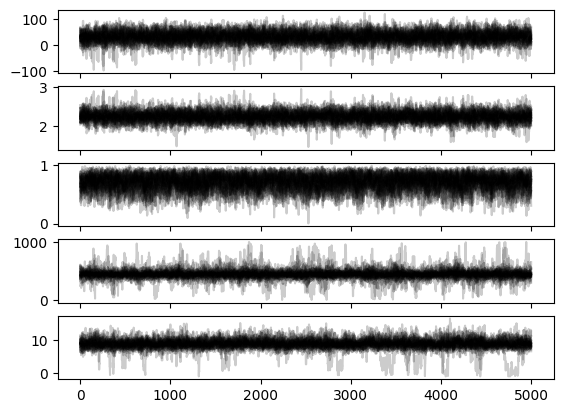

In [159]:
# Plot the five chains as above
fig, ax = plt.subplots(ndim, sharex=True)
for i in range(ndim):
    ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);

As mentioned above, the walkers start in small distributions around the maximum likelihood values and then they quickly wander and start exploring the full posterior distribution. In fact, after fewer than 50 steps, the samples seem pretty well “burnt-in”. That is a hard statement to make quantitatively, but we can look at an estimate of the integrated autocorrelation time (see the Autocorrelation analysis & convergence tutorial for more details):


In [160]:
tau = sampler.get_autocorr_time()
print(tau)

[54.52491501 53.57779775 56.80561133 61.89720444 57.39903355]


This suggests that only about 75 steps are needed for the chain to “forget” where it started. It’s not unreasonable to throw away a few times this number of steps as “burn-in”. Let’s discard the initial 200 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:

In [161]:
flat_samples = sampler.get_chain(discard=200, thin=40, flat=True)
print(flat_samples.shape)

(3840, 5)


The corner plot shows all the one and two dimensional projections of the posterior probability distributions of your parameters. This is useful because it quickly demonstrates all of the covariances between parameters. Also, the way that you find the marginalized distribution for a parameter or set of parameters using the results of the MCMC chain is to project the samples into that plane and then make an N-dimensional histogram. That means that the corner plot shows the marginalized distribution for each parameter independently in the histograms along the diagonal and then the marginalized two dimensional distributions in the other panels.

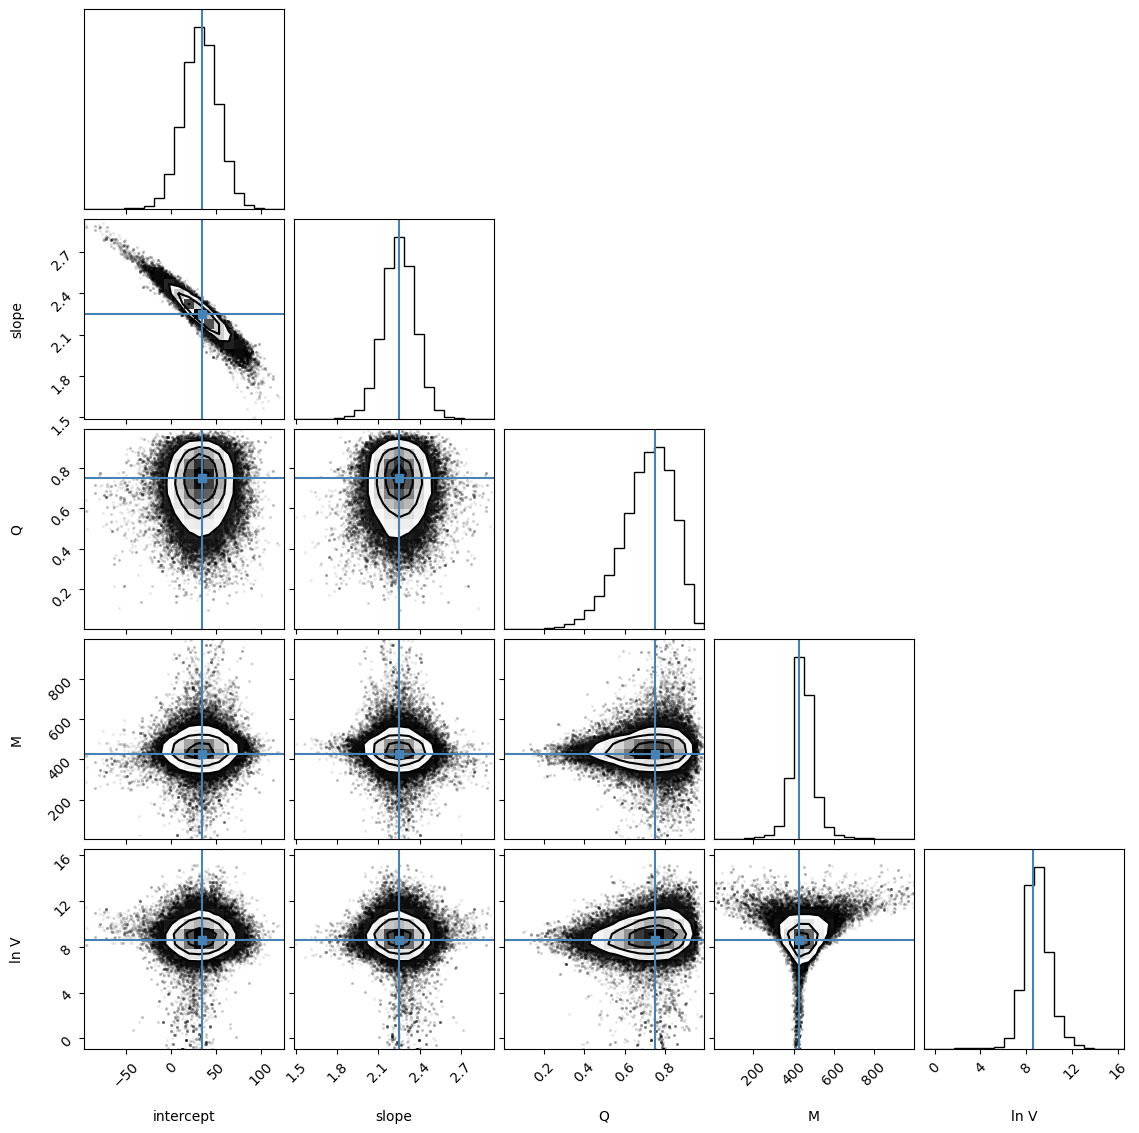

In [162]:
# Use corner.py to visualize the three-dimensional posterior
import corner
corner.corner(sampler.flatchain, truths=[35,2.25,0.75,425.,8.6],
              labels=['intercept', 'slope', 'Q', 'M', 'ln V']);

Looks pretty good! We just need to extract the parameters and uncertainties.

In [163]:
# Extract parameters we care about
b_samples = flat_samples[:, 0]
m_samples = flat_samples[:, 1]

# Calculate statistics
b_median = np.median(b_samples)
b_std = np.std(b_samples)
b_16, b_84 = np.percentile(b_samples, [16, 84])

m_median = np.median(m_samples)
m_std = np.std(m_samples)
m_16, m_84 = np.percentile(m_samples, [16, 84])

print("""Bayesian mixture model results:
    m = {0} ± {1}
    b = {2} ± {3}
""".format(m_median, m_std, b_median, b_std))


Bayesian mixture model results:
    m = 2.2529656682785824 ± 0.11905396476490025
    b = 32.60655558223448 ± 19.46809858507016



One last thing to recognize that we can assign a probabliity of being an outlier to each point using Bayes theorem.
$$
P(outlier \mid data) = \frac{P(data \mid outlier) \ P(outlier)}{P(data)}
$$
where $P(data) = P(data \mid fg) \ P(fg) + P(data \mid bg) \ P(bg)$. We define this using the code below, using the [log-sum-exp trick](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/) for numerical stability.

In [168]:
def compute_outlier_probabilities(theta, x, y, dy):
    """
    Compute the probability that each data point is an outlier (background).
    This can be used after fitting to identify which points are likely outliers.
    """
    b, m, Q, Mm, lnV = theta
    # Get log likelihoods for each model
    lnL_fg = lnlike_fg(theta, x, y, dy)
    lnL_bg = lnlike_bg(theta, x, y, dy)

    lnQ = np.log(Q)
    ln1mQ = np.log(1.0 - Q)

    # P(outlier|data) = (1-Q)*L_bg / (Q*L_fg + (1-Q)*L_bg)
    # In log space, we need to be careful
    lnP_outlier = ln1mQ + lnL_bg - np.logaddexp(lnQ + lnL_fg, ln1mQ + lnL_bg)

    return np.exp(lnP_outlier)
